In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [61]:
df = pd.read_csv('../other/frac_merge_peak.csv')

In [62]:
df.columns

Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak'],
      dtype='object')

In [63]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster', u'XEC_FIELD', u'Reservoir']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(133, 21)

In [99]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')


In [102]:
data = dict(x=standardize_2sd(X_train.drop([u'XEC_FIELD', u'Reservoir'], axis=1)), y=y_train)

with pm.Model() as mdl_pooled:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.Normal())
    step = pm.NUTS()
    trc_pooled = pm.sample(2000, step, progressbar=True)

Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:51<00:00, 38.58it/s]


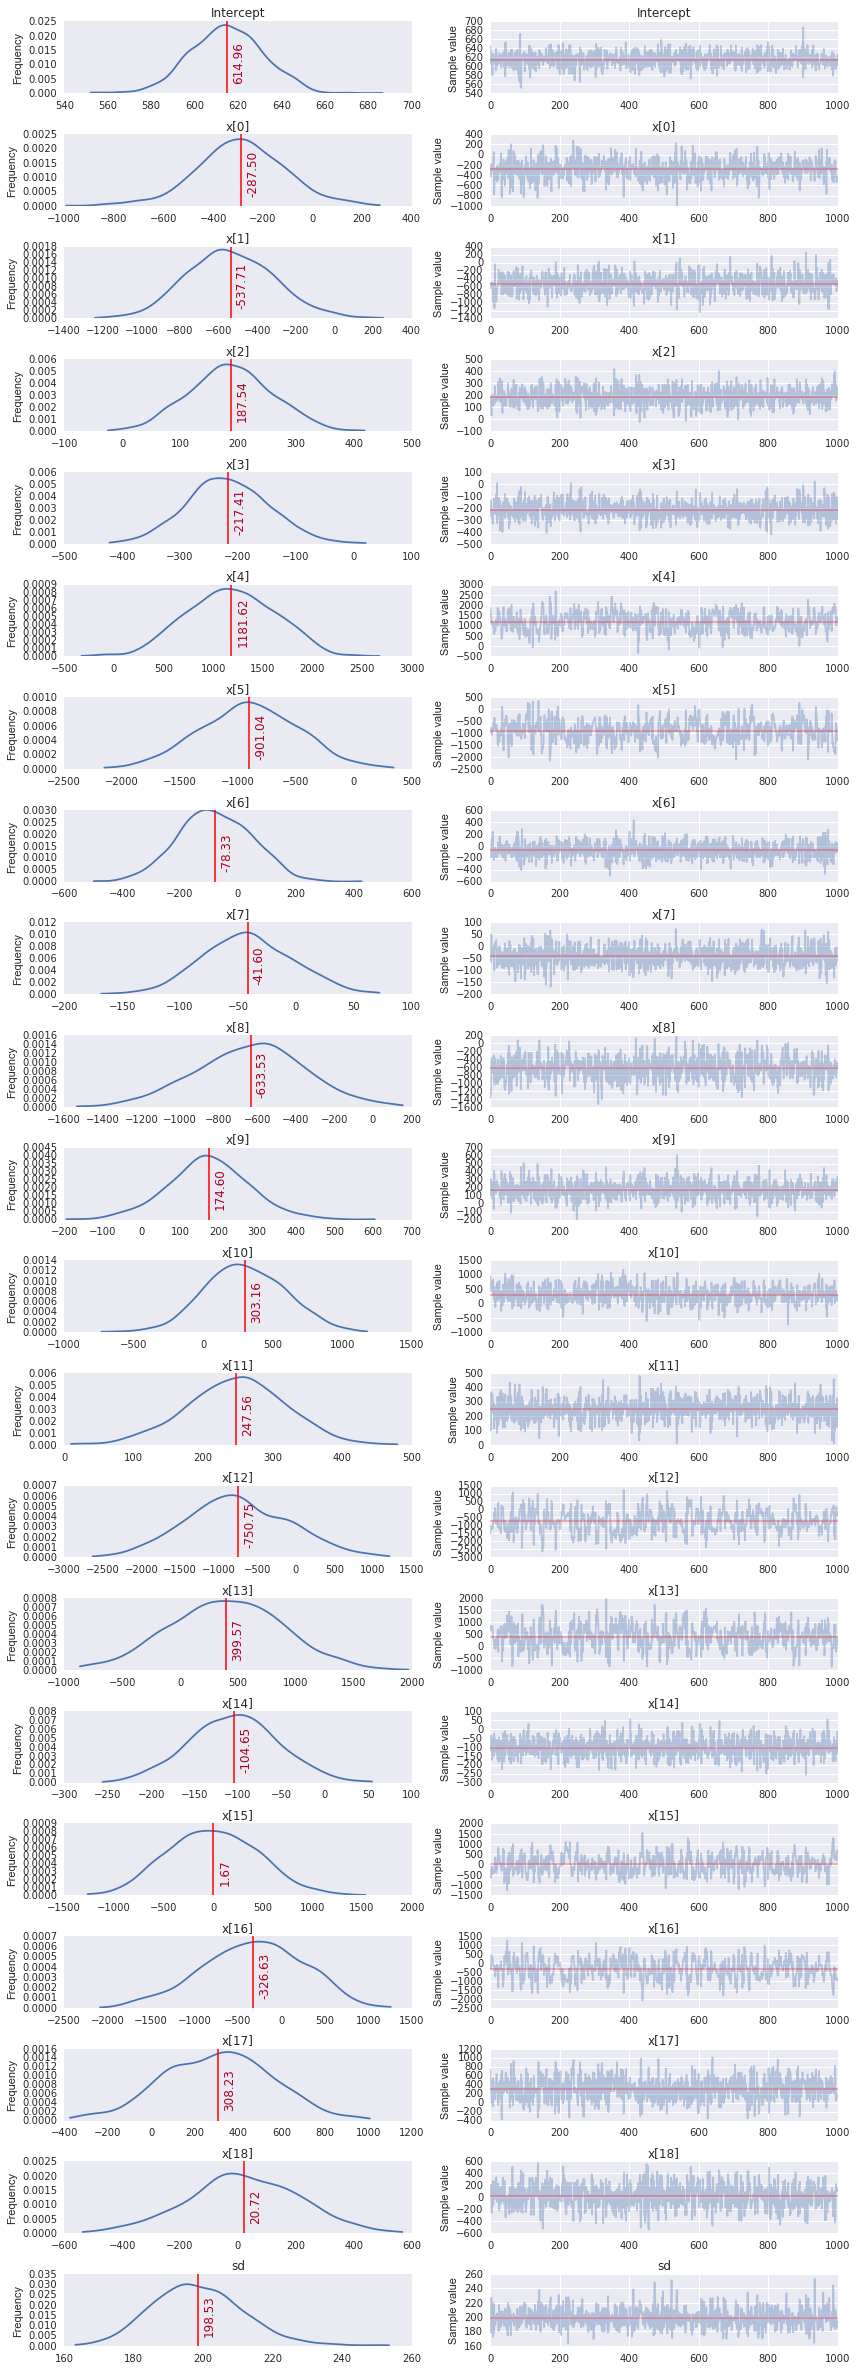

In [103]:
plot_traces(trc_pooled, retain=1000)

In [110]:
pm.df_summary(trc_pooled[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,614.962621,16.745383,0.530794,585.120093,647.769654
x[0],-287.497714,179.539640,6.043391,-622.496750,112.139848
x[1],-537.707738,226.995904,6.578289,-940.856756,-58.952031
x[2],187.542565,71.141284,2.235596,50.174814,321.261555
x[3],-217.405495,70.961069,2.224040,-344.164919,-72.408214
x[4],1181.619735,444.631985,23.240769,318.245947,1955.007747
x[5],-901.038755,429.946867,22.267882,-1789.738405,-106.518366
x[6],-78.332751,126.724464,3.928370,-311.493812,161.168877
x[7],-41.600926,39.173594,1.278271,-113.905771,34.847095
x[8],-633.525667,281.488703,10.862431,-1211.018795,-90.619294


In [113]:
X_OLS = sm.add_constant(standardize_2sd(X_train.drop([u'XEC_FIELD', u'Reservoir'], axis=1)))
model = sm.OLS(y_train, X_OLS)
model = model.fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               OIL_Peak   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     6.851
Date:                Sun, 06 Nov 2016   Prob (F-statistic):           1.14e-11
Time:                        20:48:42   Log-Likelihood:                -881.57
No. Observations:                 133   AIC:                             1803.
Df Residuals:                     113   BIC:                             1861.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               615.9413     17.21

In [119]:
model = LinearRegression()
rfe = RFE(model, 1)
fit = rfe.fit(standardize_2sd(X_train.drop(['XEC_FIELD', 'Reservoir'], axis=1)), y_train)
rank_all = []
for col, rank in sorted(zip(X_train.drop(['XEC_FIELD', 'Reservoir'], axis=1).columns, fit.ranking_), key=lambda x : x[1]):
    print col, rank
    rank_all.append(col)

Rate/Ft 1
Perfs/Cluster 2
Prop_Lbs/Ft 3
Rate/Perf 4
Prop_Lbs/Cluster 5
Rate/Cluster 6
Cluster_Spacing 7
Avg_Pressure 8
Prop_Lbs/Perf 9
ISIP/Ft 10
Clusters/Stage 11
Max_Rate 12
Fluid_Gal/Ft 13
#_of_Stages 14
Max_Pressure 15
Avg_Prop_Conc 16
Fluid_Gal/Cluster 17
Fluid_Gal/Perf 18
Max_Prop_Conc 19


//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-1000, 1000)

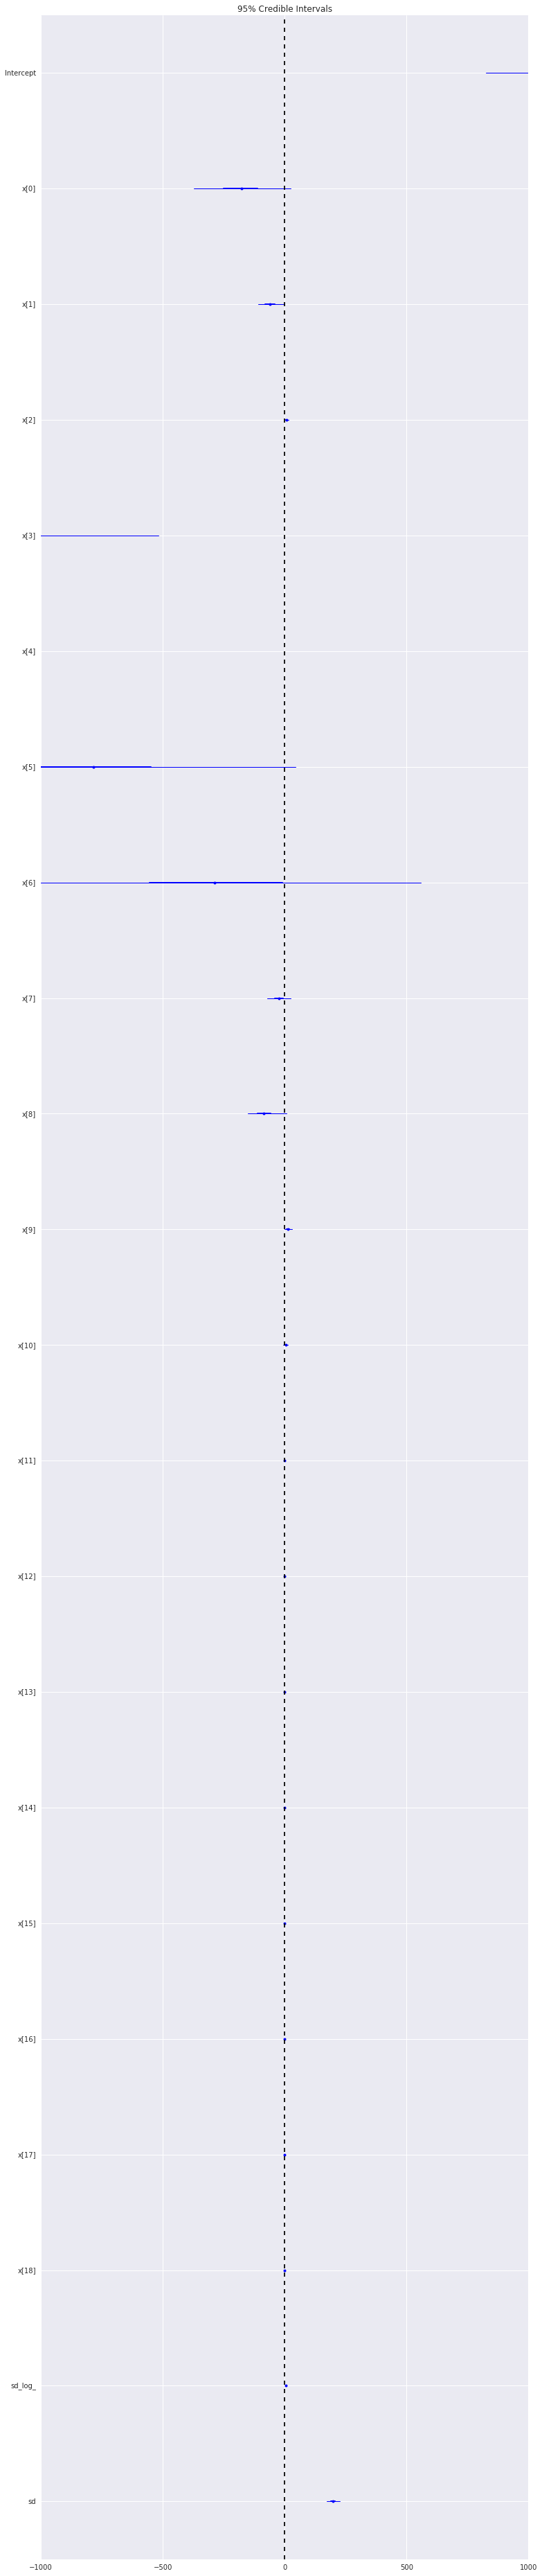

In [77]:
plt.figure(figsize=(12, 60))
pm.forestplot(traces)
# plt.savefig('../../Downloads/forestplot.png', dpi=400)
plt.xlim(-1000, 1000)

In [55]:
field = pd.Categorical(df['XEC_FIELD']).codes
reservoir = pd.Categorical(df['Reservoir']).codes

In [76]:
pm.glm.plot_posterior_predictive(traces, samples=100)

KeyError: 'x'